In [1]:
import sys
sys.path.insert(1, '../')

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd

from reprclust.reproducibility import reproducibility
from reprclust.cluster_methods import (CompleteClusterMethod, WardClusterMethod, 
                                       KMeansClusterMethod, GMMClusterMethod)
from reprclust.cluster_metrics import (ARI, AMI, CorrelationScore, InstabilityScore, rand_instability_score)
from reprclust import sim

from scipy.spatial.distance import squareform
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cross_validation import ShuffleSplit
from time import time

In [3]:
# switch this to False to avoid plotting figures
plot_figs = True

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
# target RDMs
subordinate = np.array([[0,2.,2,2,2,2],
                        [2,0,2,2,2,2],
                        [2,2,0,2,2,2],
                        [2,2,2,0,2,2],
                        [2,2,2,2,0,2],
                        [2,2,2,2,2,0]])
subordinate = squareform(subordinate)

superordinate = np.array([[0,1.,2,2,2,2],
                          [1,0,2,2,2,2],
                          [2,2,0,1,2,2],
                          [2,2,1,0,2,2],
                          [2,2,2,2,0,1],
                          [2,2,2,2,1,0]])
superordinate = squareform(superordinate)


animate = np.array([[0,1.,1,2,2,2],
                    [1,0,1,2,2,2],
                    [1,1,0,2,2,2],
                    [2,2,2,0,1,1],
                    [2,2,2,1,0,1],
                    [2,2,2,1,1,0]])
animate = squareform(animate)

continuum = np.array([[0,.4,.8,1.2,1.6,2],
                      [.4,0,.4,.8,1.2,1.6],
                      [.8,.4,0,.4,.8,1.2],
                      [1.2,.8,.4,0,.4,.8],
                      [1.6,1.2,.8,.4,0,.4],
                      [2,1.6,1.2,.8,.4,0]])
continuum = squareform(continuum)

faces = np.array([[0,1.,2,2,2,2],
                  [1,0,2,2,2,2],
                  [2,2,0,2,2,2],
                  [2,2,2,0,2,2],
                  [2,2,2,2,0,2],
                  [2,2,2,2,2,0]])
faces = squareform(faces)

np.random.seed(42)
random_rsa = np.random.uniform(0, 2, 15)

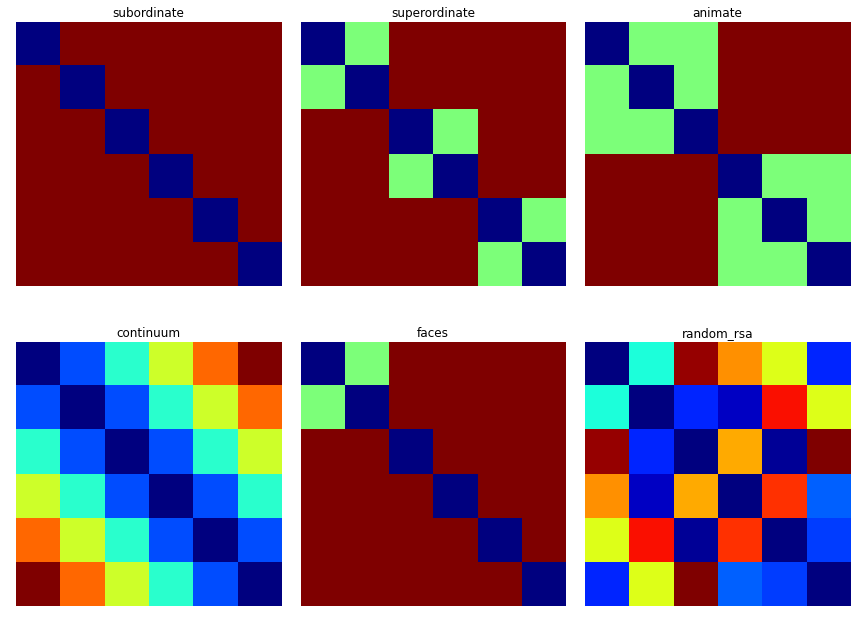

In [6]:
if plot_figs:
    rsas = ['subordinate', 'superordinate', 'animate',
            'continuum', 'faces', 'random_rsa']

    fig = pl.figure(figsize=(12, 10))
    for i, rsa in enumerate(rsas):
        ax = fig.add_subplot(2, 3, i+1)
        ax.imshow(squareform(eval(rsa)), interpolation='nearest')
        ax.set_title(rsa)
        ax.axis('off')
        pl.tight_layout()

In [7]:
radius_sphere = 6.5

In [8]:
# generate simulated data
np.random.seed(101)
a_clean, cluster_truth, dss = \
    sim.simple_sim1((50, 50), 
                    [subordinate, superordinate,animate, continuum, faces, random_rsa],
                    roi_neighborhood=sim.Sphere(radius_sphere),
                    nruns=1, nsubjects=10,
                    # noise components -- we just add normal for now also with
                    # spatial smoothing to possibly create difference in noise
                    # characteristics across different kinds
                    #
                    # "Instrumental noise" -- generic nuisance
                    noise_independent_std=5, noise_independent_smooth=1.5,
                    # "Intrinsic signal", specific per each subject (due to
                    # motion, whatever) -- might be fun for someone to cluster,
                    # but irrelevant for us
                    noise_subject_n=1, noise_subject_std=2, noise_subject_smooth=2.,
                    # "Intrinsic common signal" -- probably generalizes across
                    # subjects and fun for someone studying veins to get those
                    # reproducible clusters.  It will be mixed in also with
                    # different weights per each run.
                    # Again -- might be fun for someone to cluster, but not for us
                    # since it would not be representative of the original signal
                    noise_common_n=1, noise_common_std=0, noise_common_smooth=2.)

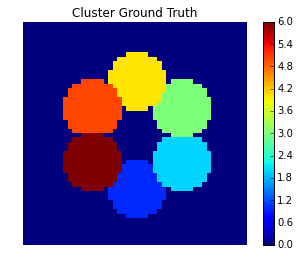

In [9]:
if plot_figs:
    fig = figure()
    ax = fig.add_subplot(111)
    img = ax.imshow(cluster_truth, interpolation='nearest')
    ax.set_title('Cluster Ground Truth');
    ax.axis('off');
    plt.colorbar(img);

In [10]:
# Extract the samples from the datasets and fisher transform them
samples = [np.arctanh(ds.samples).T for ds in dss]

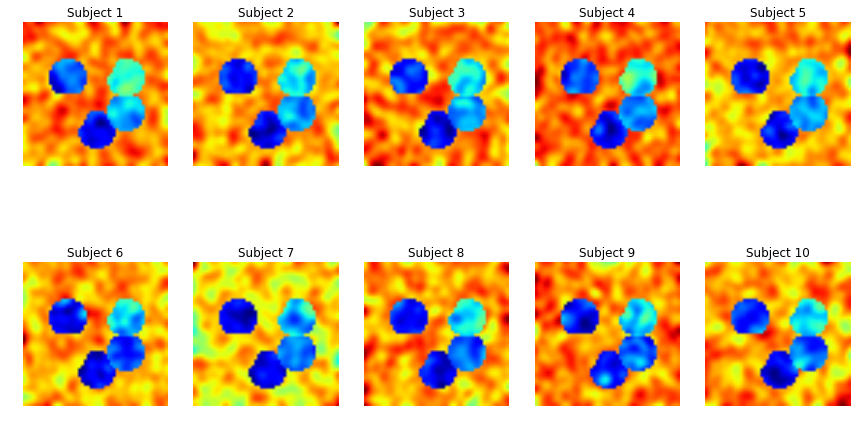

In [11]:
# Plot average across DSM
if plot_figs:
    fig = figure(figsize=(12, 10))
    for i in range(10):
        ax = fig.add_subplot(2, 5, i+1)
        ax.imshow(np.mean(samples[i].T, axis=0).reshape(*cluster_truth.shape))
        ax.axis('off')
        ax.set_title('Subject {0}'.format(i+1))
        pl.tight_layout()

In [12]:
# create 'connectivity' matrix for this 2D image
connectivity = grid_to_graph(*cluster_truth.shape)

In [13]:
n_splits = 20
ks = np.arange(2, 11)
corr_score_type = 'pearson'

# run simulation for all methods -- takes less than 10m on a quad-core macbook air
splitter = ShuffleSplit(len(samples), n_iter=n_splits, test_size=.5,
                        random_state=42)

In [14]:
algorithms = {'complete': CompleteClusterMethod(),
              'ward-str': WardClusterMethod(connectivity=connectivity),
              'ward-unstr': WardClusterMethod(),
              'kmeans': KMeansClusterMethod(),
              'gmm-tied': GMMClusterMethod(covariance_type='tied'),
              'gmm-diag': GMMClusterMethod(covariance_type='diag'),
              'gmm-sph': GMMClusterMethod(covariance_type='spherical'),
              'gmm-full': GMMClusterMethod(covariance_type='full')}

In [15]:
# set up additional cluster metrics

# normalization scores for instability
normalization_scores = rand_instability_score(ks, connectivity.size, 20)
instability_score = InstabilityScore(normalization_scores)

# correlation score
correlation_score = CorrelationScore(corr_type=corr_score_type)

# ari, ami
ari = ARI()
ami = AMI()

cluster_metrics = [ari, ami, instability_score, correlation_score]

In [16]:
result = {}
for key, cluster_method in algorithms.items():
    print 'Running {0}'.format(key),
    tstart = time()
    r = reproducibility(samples, splitter, cluster_method, ks=ks, ground_truth=cluster_truth.reshape(-1,),
                        cluster_metrics=cluster_metrics, n_jobs=4, verbose=0)
    print 'done in {0:.2f}s'.format(time()-tstart)
    result[key] = r

Running gmm-sph done in 50.81s
Running gmm-tied done in 53.85s
Running complete done in 329.17s
Running ward-str done in 22.03s
Running gmm-full done in 98.24s
Running gmm-diag done in 37.20s
Running kmeans done in 28.76s
Running ward-unstr done in 342.25s


In [17]:
def result2df(result):
    result_dict = {}
    dfs = []
    for method, value in result.items():
        result_dict[method] = {}
        for metric, scores in value.items():
            result_dict[method][metric] = pd.Series(scores[1], index=scores[0], name=method)
        tmp = pd.DataFrame(result_dict[method])
        tmp['method'] = method
        dfs.append(tmp)
    return pd.DataFrame().append(dfs)

In [18]:
df = result2df(result)

In [19]:
fnout = 'simulation_results_rsph{0}_{1}.csv'.format(radius_sphere, corr_score_type)
df.to_csv(fnout)

In [20]:
# assuming packages reshape2, plyr, ggplot2 and R are installed, 
# run the following line to generate the image
!Rscript plot_simulated_results.R $fnout

Loading required package: reshape2
Loading required package: plyr
Loading required package: ggplot2
Loading required package: methods
Saving simulation_results_rsph6.5_pearson.pdf 
null device 
          1 
